# Read in Data

In [49]:
import pandas as pd
import numpy as np

import re
import string
import random
import operator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader

In [50]:
music = pd.read_csv('lyrics.csv')

In [51]:
len(music)

362237

In [3]:
music.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [4]:
music['genre'].unique()

array(['Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal',
       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
      dtype=object)

In [5]:
sum(music['genre'] == 'Hip-Hop')

33965

In [6]:
hh_lyrics = music[music['genre'] == 'Hip-Hop']['lyrics']

In [7]:
hh_lyrics.head()

249    (horns)...\n(chorus)\nTimbo- When you hit me o...
250    Verse 1:\nI don't drink brass monkey, like to ...
251    19 muthaphukkin 93,\nand I'm back in this bitc...
252    Hey yo man, remember that shit Eazy did a whil...
253    Yo, Dre, man, I take this bitch out to the mov...
Name: lyrics, dtype: object

# Data Cleaning

There are newlines all over the place, it's important to recognize where a line ends, but we want the new line to be its own character.

In [8]:
test_lyric = hh_lyrics[250]
test_lyric_ = test_lyric.lower()

# test_lyric_.replace('\n', ' \n ').split(' ')

In [9]:
hh_lyrics_ = [h for h in hh_lyrics if type(h) == str]
hh_lyrics_ = [h.lower() for h in hh_lyrics_]
hh_lyrics_ = [h.translate(str.maketrans('', '', string.punctuation)) for h in hh_lyrics_]

Note that originally I kept newlines in as a character, but the model only predicted newlines so I am now removing it.

In [10]:
hh_lyrics_ = [h.split() for h in hh_lyrics_]

In [11]:
counter = {}

for song in hh_lyrics_:
    for word in song:
        if word in counter.keys():
            counter[word] += 1
        else:
            counter[word] = 1

In [12]:
word2idx = {}
word2idx['<UNK>'] = 0
word2idx['<EOS>'] = 1

for k,v in counter.items():
    if v >= 10:
        word2idx[k] = len(word2idx)
        
V = len(word2idx)

In [13]:
songs = [[word2idx.get(w, 0) for w in song] + [1] for song in hh_lyrics_]

The songs have been broken down into integers which will be mapped to word embeddings. Because we're building a language model, we now need to create a dataset consisting of some leading words followed by the label, the next word up. Let's start with using 10 leading words and then predicting the eleventh word.

In [14]:
num_samples_per_song = 50
sample_size = 5
song_set = []

for song in songs:
    num_words = len(song)
    if num_words <= sample_size+1:
        break
    for _ in range(num_samples_per_song):
        start = np.random.randint(0, num_words-sample_size-1)
        song_set.append(song[start:start+sample_size+1])

In [15]:
# sum([s[-1] == 19 for s in song_set]) / len(song_set)

3% of the observations have the word 'the' as the target. The model tends to only predict the word 'the', so we're going to try removing it from the dataset and see how that affects predictions.

In [16]:
# song_set = [s for s in song_set if s[-1] != 19]

Create the dataloader

In [17]:
V

29440

In [18]:
blah = []

for song in song_set:
    try:
        blah.append(song[sample_size])
    except:
        print(song)

In [19]:
len(song_set)

42600

In [20]:
blah = np.zeros((len(song_set), V))
for i, song in enumerate(song_set):
    blah[i, song[sample_size]] = 1

In [21]:
song_set[24850]

[10251, 512, 10392, 10817, 131, 19]

Train-Test Split

In [22]:
num_obs = len(song_set)
train, test = [], []

test_ids  = random.sample(range(num_obs), num_obs // 3)
train_ids = list( set(range(num_obs)) - set(test_ids) )

for idx in train_ids:
    train.append(song_set[idx])
    
for idx in test_ids:
    test.append(song_set[idx])

In [23]:
class Songs(Dataset):
    def __init__(self, songs):
        self.x = torch.tensor( [s[:sample_size] for s in songs] )        
        self.y = torch.tensor( [s[-1] for s in songs] ).long()
        # initialize an empty array and then one-hot code the targets

#         self.y = np.zeros((len(songs), V))

#         for i, song in enumerate(songs):
#             self.y[i, song[sample_size]] = 1
#         self.y = torch.tensor(self.y)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [24]:
train_ds = Songs(train)
test_ds  = Songs(test)

train_dl = DataLoader(train_ds, 50)
test_dl  = DataLoader(test_ds, 50)

In [25]:
len( song_set )

42600

In [26]:
for x, y in train_dl:
    print(x) 
    print(y)
    break

tensor([[ 11,  12,  13,  14,  15],
        [  6,  16,  34,   6,  18],
        [  0, 125, 127,  88, 128],
        [ 47,  48,   0, 134,  21],
        [ 90, 205, 102, 206, 127],
        [ 13,   9,  19,  20,  21],
        [ 57,  63,  64,  65,  66],
        [ 24,  25,  26,  24,  25],
        [117, 118, 119, 120,  31],
        [ 68,  69,  70,  19,  71],
        [ 70,  75, 185, 146, 186],
        [127,  88, 128, 129,  34],
        [146,  50, 147, 110, 148],
        [ 18,  13,   6,  35,  21],
        [  6, 152, 153,   0, 154],
        [ 48,   0, 134,  21, 144],
        [ 83,  19, 109, 110,  46],
        [ 64,  65,  66,  67,  21],
        [  0,  26,   0,  26,  23],
        [ 25,   0,  24,  25,   0],
        [  6,  16,  34,   6,  18],
        [ 57,  94,  92,  95,  90],
        [175, 176, 177, 178,  31],
        [ 41,  42,  31,  24,  90],
        [ 24,  25,  24,  27,  28],
        [ 35,  21,  22,   0,  26],
        [ 14,  15,  16,   5,   6],
        [128, 129,  34, 102,   8],
        [ 77,  19,  

# Model

In [74]:
class LangModel(torch.nn.Module):
    def __init__(self, vocab_size=V, emb_size=30, dropout=0.9, hidden_size=10):
        super(LangModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding   = torch.nn.Embedding(vocab_size, embedding_dim=emb_size)
        self.LSTM = torch.nn.LSTM(input_size=emb_size, hidden_size=hidden_size,
                                  batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, 2*hidden_size)
        self.fc2 = torch.nn.Linear(2*hidden_size, vocab_size)
        self.fc3 = torch.nn.Linear(hidden_size, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # we want the final hidden layer, so we will take the
        # hidden part of the h_c output of the LSTM
        batch_size = x.shape[0]
        x = self.embedding(x)
        x, h_c = self.LSTM(x)
        x = self.dropout(h_c[0])
        x = x.squeeze()
        x = self.fc3(x)
        return x.squeeze().double()

In [15]:
def train_model(mod, n_epochs, train_loss=[], test_loss=[]):
    for i in range(n_epochs):
        # train
        total_loss, trials = 0, 0
        mod.train()
        for x, y in train_dl:
            y_hat = mod(x)
            optimizer.zero_grad()
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            trials += y.shape[0]
            total_loss += loss.item()
        train_loss.append(total_loss / trials)
        
        # test
        if i % 5 == 4:
            total_test_loss, test_trials = 0, 0
            mod.eval()
            for x, y in test_dl:
                test_trials += y.shape[0]
                y_hat = model(x)
                loss = criterion(y_hat, y)
                total_test_loss += loss.item()    
            test_loss.append(total_test_loss / test_trials)

 
    sns.lineplot(x=1+np.arange(len(train_loss)),
                 y=train_loss)
    sns.lineplot(x=5*(np.arange(len(test_loss))+1),
                 y=test_loss)
    plt.show()
    
    return train_loss, test_loss

In [16]:
model = LangModel()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

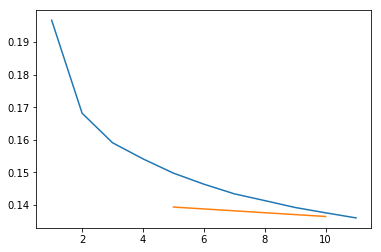

In [35]:
train_loss_, test_loss_ = train_model(model, 11)

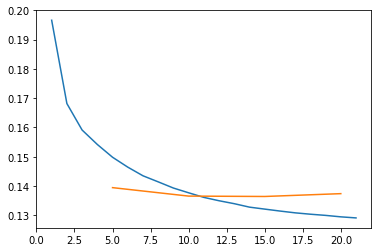

In [36]:
train_loss_, test_loss_ = train_model(model, 10, train_loss=train_loss_, test_loss=test_loss_)

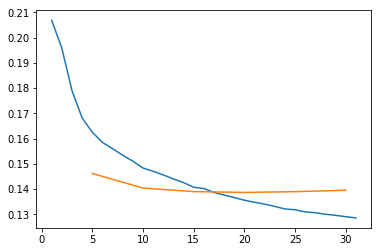

In [65]:
train_loss_, test_loss_ = train_model(model, 10, train_loss=train_loss_, test_loss=test_loss_)

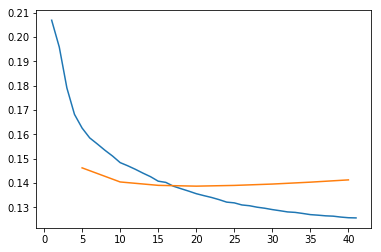

In [66]:
train_loss_, test_loss_ = train_model(model, 10, train_loss=train_loss_, test_loss=test_loss_)

# Load in Model

In [53]:
! ls

DJ_Data_Cleaner.ipynb continue_train.py     results2.txt
EMCEE_ARMR.ipynb      lyrics.csv            train.py
MODEL.pth             nohup.out
MODEL2.pth            results.txt


In [75]:
model = LangModel()
model.load_state_dict(torch.load('./MODEL2.pth'))
model.eval()

LangModel(
  (embedding): Embedding(29440, 30)
  (LSTM): LSTM(30, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=29440, bias=True)
  (fc3): Linear(in_features=10, out_features=29440, bias=True)
  (dropout): Dropout(p=0.9)
)

In [80]:
import pickle 

with open('word2idx.pickle', 'rb') as f:
    word2idx = pickle.load(f)

In [81]:
idx2word = {v:k for k,v in word2idx.items()}

In [94]:
start_words = 'it was all a dream i used to read wordup magazine'.split(' ')
start_idx = [word2idx.get(word, word2idx['<UNK>']) for word in start_words]
rap = start_idx

k = 100

for _ in range(25):
    pred_ = model( torch.tensor([rap]) ).tolist()
    pred_ = [(p, i) for i,p in enumerate(pred_)]
    pred_.sort(key=lambda x: x[0], reverse=True)

    predict_position = np.random.randint(k)
    index = pred_[predict_position][1]

    rap.append(index)    

In [95]:
print(' '.join([idx2word[word] for word in rap]))

it was all a dream i used to read <UNK> magazine all 50 make they for shit tell on bitch give kids shit down we niggas is no time shit all them or want if this


In [ ]:
last name ever 
first name greatest 
throw many after satan 
bitches believe space guess 
head could smell smoke den 
that hold place really without nothin 
ladies remember brother versus kids best